Importing Packages

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, DoubleType, BooleanType, FloatType
from pyspark.sql.functions import col, isnull, sum , corr ,udf,isnan,count,when,mean
import pymongo
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
import math
from numpy import isinf

Dumping Data into MongoDB and Removing Unecessary columns

In [3]:

# Create a SparkSession
spark = SparkSession.builder \
    .appName("MongoDB Data Loading") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

# Define the schema
schema = StructType([
    StructField("overall", DoubleType(), nullable=True),
    StructField("vote", StringType(), nullable=True),
    StructField("reviewerID", StringType(), nullable=True),
    StructField("asin", StringType(), nullable=True),
    StructField("reviewerName", StringType(), nullable=True),
    StructField("reviewText", StringType(), nullable=True),
    StructField("summary", StringType(), nullable=True),
    StructField("unixReviewTime", IntegerType(), nullable=True)
])

# Read the JSON dataset with specified schema
df = spark.read.format("json").option("inferSchema", "false").schema(schema).load("Review.json")

# Drop rows with all null values
df = df.dropna(how="all")

# Limit the number of records to 60 million (or 30GB of data)
max_records = 60000000
if df.count() > max_records:
    df = df.limit(max_records)

# Set the batch size for writing to MongoDB
batchSize = 5000

# Write the DataFrame to MongoDB in batches
df.write.format("mongo") \
    .option("uri", "mongodb://localhost:27017/BDA.amazon") \
    .option("bulksize", batchSize) \
    .option("batchsize", batchSize) \
    .option("replaceDocument", "false") \
    .mode("append") \
    .save()

# Stop the SparkSession
spark.stop()

print("DB created")


:: loading settings :: url = jar:file:/home/umar/Downloads/spark-3.4.0-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/umar/.ivy2/cache
The jars for the packages stored in: /home/umar/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6ce11b92-67c5-46af-ae85-df3593790fc8;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 313ms :: artifacts dl 20ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |

DB created


In [5]:
df.printSchema()

root
 |-- overall: double (nullable = true)
 |-- vote: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: integer (nullable = true)



Reading Data from MongoDB

In [4]:
spark = SparkSession.builder \
    .appName("MongoDB EDA") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/BDA.amazon") \
    .config("spark.mongodb.output.uri", "mongodb://localhost/BDA.amazon") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1')\
    .getOrCreate()


EDA AND CLEANING

In [5]:
# Read data from MongoDB into a DataFrame
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
df.show()

+--------------------+----------+-------+--------------------+--------------+----------------+--------------------+--------------+----+
|                 _id|      asin|overall|          reviewText|    reviewerID|    reviewerName|             summary|unixReviewTime|vote|
+--------------------+----------+-------+--------------------+--------------+----------------+--------------------+--------------+----+
|{644e1d8023114e2a...|B017O9P72A|    1.0|Alexa is not able...|A27BTSGLXK2C5K|Jacob M. Wessler|VERY Buggy, doesn...|    1449792000|null|
|{644e1d8023114e2a...|B017O9P72A|    4.0|Alexa works great...|A27ZJ1NCBFP1HZ|            Greg|      So Far So Good|    1449532800|   5|
|{644e1d8023114e2a...|B017O9P72A|    1.0|Weak!!\n\nAlexa d...| ACCQIOZMFN4UK|        Da-Gr8-1|         Time waster|    1449446400|  11|
|{644e1d8023114e2a...|B017O9P72A|    2.0|Can only control ...|A3KUPJ396OQF78|   Larry Russlin|               Buggy|    1449273600|null|
|{644e1d8023114e2a...|B017O9P72A|    1.0|this wo

Counting Null Values

In [6]:
# Count null values in each column
null_counts = df.select([sum(col(column).isNull().cast("integer")).alias(column) for column in df.columns])

# Display the null counts
null_counts.show()

+---+----+-------+----------+----------+------------+-------+--------------+--------+
|_id|asin|overall|reviewText|reviewerID|reviewerName|summary|unixReviewTime|    vote|
+---+----+-------+----------+----------+------------+-------+--------------+--------+
|  0|   0|      0|     37754|         0|        4116|  16015|             0|52189947|
+---+----+-------+----------+----------+------------+-------+--------------+--------+



In [7]:
df = df.drop("vote")
df.show(10)

+--------------------+----------+-------+--------------------+--------------+----------------+--------------------+--------------+
|                 _id|      asin|overall|          reviewText|    reviewerID|    reviewerName|             summary|unixReviewTime|
+--------------------+----------+-------+--------------------+--------------+----------------+--------------------+--------------+
|{644e1d8023114e2a...|B017O9P72A|    1.0|Alexa is not able...|A27BTSGLXK2C5K|Jacob M. Wessler|VERY Buggy, doesn...|    1449792000|
|{644e1d8023114e2a...|B017O9P72A|    4.0|Alexa works great...|A27ZJ1NCBFP1HZ|            Greg|      So Far So Good|    1449532800|
|{644e1d8023114e2a...|B017O9P72A|    1.0|Weak!!\n\nAlexa d...| ACCQIOZMFN4UK|        Da-Gr8-1|         Time waster|    1449446400|
|{644e1d8023114e2a...|B017O9P72A|    2.0|Can only control ...|A3KUPJ396OQF78|   Larry Russlin|               Buggy|    1449273600|
|{644e1d8023114e2a...|B017O9P72A|    1.0|this worked great...|A1U1RE1ZI19E1H|      

In [8]:
df = df.fillna({"reviewText": "No review available"})
df = df.fillna({"reviewerName":"Amazon Customer"})
df = df.fillna({"summary":"No Summary Available"})

In [14]:
# Count null values in each column
null_counts = df.select([sum(col(column).isNull().cast("integer")).alias(column) for column in df.columns])

# Display the null counts
null_counts.show()

+---+----+-------+----------+----------+------------+-------+--------------+
|_id|asin|overall|reviewText|reviewerID|reviewerName|summary|unixReviewTime|
+---+----+-------+----------+----------+------------+-------+--------------+
|  0|   0|      0|         0|         0|           0|      0|             0|
+---+----+-------+----------+----------+------------+-------+--------------+



Length of Reviews

In [17]:
# Calculate the length of reviewText
df = df.withColumn("reviewTextLength", F.length(df["reviewText"]))

# Relationship between reviewTextLength and overall ratings
df.select("reviewTextLength", "overall").show(10)



+----------------+-------+
|reviewTextLength|overall|
+----------------+-------+
|             363|    1.0|
|             832|    4.0|
|             114|    1.0|
|              55|    2.0|
|              55|    1.0|
|              11|    5.0|
|              46|    1.0|
|              47|    1.0|
|             204|    1.0|
|             112|    1.0|
+----------------+-------+
only showing top 10 rows



CORREALTION

In [22]:
columns = ['overall', 'unixReviewTime']

# Convert 'overall' and 'unixReviewTime' columns to numeric types
df = df.withColumn('overall', col('overall').cast('double'))
df= df.withColumn('unixReviewTime', col('unixReviewTime').cast('double'))

# Calculate the correlation between columns
correlations = df.select([corr(col1, col2).alias(col1 + '_' + col2) for col1 in columns for col2 in columns if col1 != col2])

# Show the correlation matrix
correlations.show()

+----------------------+----------------------+
|overall_unixReviewTime|unixReviewTime_overall|
+----------------------+----------------------+
|  0.032438376330201774|  0.032438376330201774|
+----------------------+----------------------+



Most Frequent Overall rating given

In [32]:
overall_counts = df.groupBy('overall').count()

# Retrieve the most frequent value
most_frequent_value = overall_counts.orderBy(col('count').desc()).first()['overall']

print("The most frequent value in the 'overall' column is:", most_frequent_value)

The most frequent value in the 'overall' column is: 5.0


PLOTS

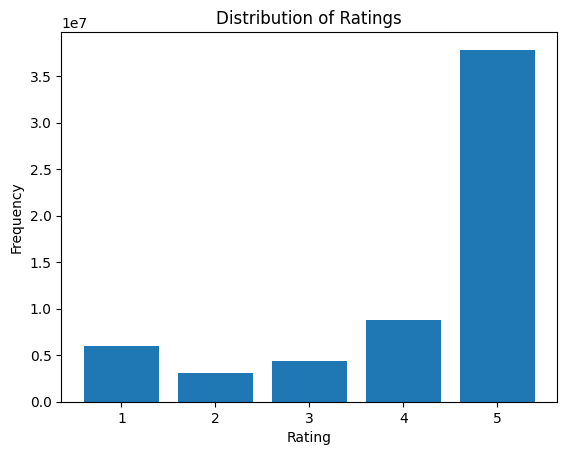

In [33]:
# Count the frequency of each rating
rating_counts = df.groupBy('overall').count().orderBy('overall')

# Convert the Spark DataFrame to Pandas DataFrame for plotting
rating_counts_pd = rating_counts.toPandas()

# Create a bar plot
plt.bar(rating_counts_pd['overall'], rating_counts_pd['count'])

# Set plot title and labels
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()


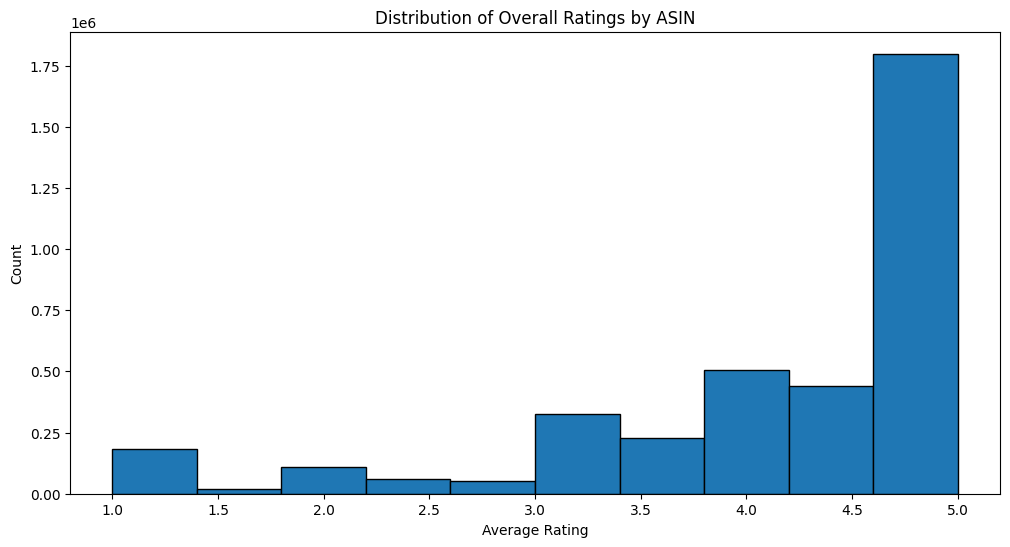

In [11]:
rating_by_asin = df.groupBy('asin').agg(F.avg('overall').alias('avg_rating'))

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
rating_pd = rating_by_asin.toPandas()

# Plot the distribution of overall ratings for each 'asin'
plt.figure(figsize=(12, 6))
plt.hist(rating_pd['avg_rating'], bins=10, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.title('Distribution of Overall Ratings by ASIN')
plt.show()

Sentiment Analysis

In [74]:
# Create a smaller DataFrame with the first 10 reviews
# df_small = df.limit(10)

# Instantiate the SentimentIntensityAnalyzer
df1 = df.filter(~isnull(col('reviewText')))
sia = SentimentIntensityAnalyzer()

# Define a UDF (User-Defined Function) to get the sentiment score for each review
get_sentiment_score = udf(lambda text: sia.polarity_scores(text)['compound'], FloatType())

# Apply the sentiment analysis function to the 'reviewText' column
df_with_sentiment = df1.withColumn('sentiment_score', get_sentiment_score(df['reviewText']))

# Display the resulting DataFrame with the sentiment scores for the first 10 reviews
df_with_sentiment.select('reviewText', 'sentiment_score').show()

+--------------------+---------------+
|          reviewText|sentiment_score|
+--------------------+---------------+
|Alexa is not able...|         0.1027|
|Alexa works great...|         0.7816|
|Weak!!\n\nAlexa d...|        -0.7418|
|Can only control ...|            0.0|
|this worked great...|         0.6705|
|         Great skill|         0.6249|
|Pretty crappy. Wo...|        -0.1027|
|Not happy. Can no...|        -0.4585|
|Can not connect a...|        -0.2635|
|The service works...|        -0.3491|
|The LifX bulb is ...|         0.7783|
|So easy to connec...|         0.7951|
|I use &ldquo;Echo...|         0.1984|
|Can&rsquo;t conne...|            0.0|
|I haven't had any...|         0.3612|
|This app forces y...|         0.8025|
|Red all steps and...|            0.0|
|This skill works ...|         0.9779|
|Who would think y...|        -0.7096|
|Lifx is a weird w...|         0.3566|
+--------------------+---------------+
only showing top 20 rows



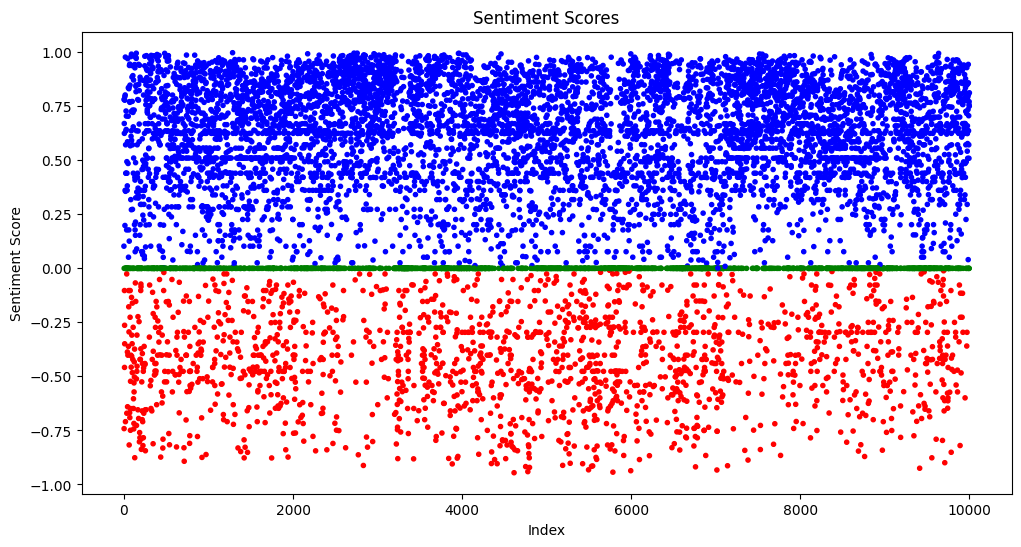

In [76]:
# df_with_sentiment.select('asin', 'sentiment_score').show()
df_plot = df_with_sentiment.select('asin', 'sentiment_score').limit(10000)
pandas_df= df_plot.toPandas()
pandas_df.sort_values('asin', inplace=True)
# Create a line chart
plt.figure(figsize=(12, 6))
colors = ['red' if score < 0 else 'blue' if score > 0 else 'green' for score in pandas_df['sentiment_score']]

plt.scatter(pandas_df.index, pandas_df['sentiment_score'], marker='.', linestyle='-',color=colors)

# Set plot title and labels
plt.title('Sentiment Scores')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')

# Show the plot
plt.show()

Phase 2

In [9]:
# Select the required columns for collaborative filtering
subdf = df.select("reviewerID", "asin", "overall")

# Show the resulting DataFrame
subdf.show(10)


+--------------+----------+-------+
|    reviewerID|      asin|overall|
+--------------+----------+-------+
|A27BTSGLXK2C5K|B017O9P72A|    1.0|
|A27ZJ1NCBFP1HZ|B017O9P72A|    4.0|
| ACCQIOZMFN4UK|B017O9P72A|    1.0|
|A3KUPJ396OQF78|B017O9P72A|    2.0|
|A1U1RE1ZI19E1H|B017O9P72A|    1.0|
|A3TXR8GLKS19RE|B017O9P72A|    5.0|
| AVIWE1LJXCG77|B017O9P72A|    1.0|
|A1FOHYK23FJ6CN|B017O9P72A|    1.0|
|A1RRDX9AOST1AN|B017O9P72A|    1.0|
| AA4DHYT5YSSIT|B017O9P72A|    1.0|
+--------------+----------+-------+
only showing top 10 rows



In [38]:
# Set batch size
batch_size = 10000

# Convert reviewerID to numeric
userIndexer = StringIndexer(inputCol="reviewerID", outputCol="userIndex",handleInvalid="skip")
indexedData = userIndexer.fit(subdf.limit(batch_size)).transform(subdf)

# Convert asin to numeric
itemIndexer = StringIndexer(inputCol="asin", outputCol="itemIndex",handleInvalid="skip")
indexedData = itemIndexer.fit(indexedData.limit(batch_size)).transform(indexedData)

# Select only the required columns for collaborative filtering
cfData = indexedData.select("userIndex", "itemIndex", "overall")
cfData.write.json("cfData_ex.json")



In [11]:
# Count null values in each column
null_counts = cfData.select([sum(col(column).isNull().cast("integer")).alias(column) for column in cfData.columns])

# Display the null counts
null_counts.show()

+---------+---------+-------+
|userIndex|itemIndex|overall|
+---------+---------+-------+
|        0|        0|      0|
+---------+---------+-------+



In [39]:
cfData.dropna()

DataFrame[userIndex: double, itemIndex: double, overall: double]

In [43]:
# Split the data into training and testing sets
(training, test) = cfData.randomSplit([0.8, 0.2])

# Build the collaborative filtering model
als = ALS(maxIter=10, regParam=0.01, userCol="userIndex", itemCol="itemIndex", ratingCol="overall",coldStartStrategy="drop")
model = als.fit(training)

# Generate predictions on the test set
predictions = model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

# Evaluate the model
evaluator = RegressionEvaluator(metricName="mae", labelCol="overall", predictionCol="prediction")
mae = evaluator.evaluate(predictions)
print("Mean Absoulte Error Error (MAE):", mae)

Root Mean Squared Error (RMSE): 0.6913982156919692


Mean Absoulte Error Error (MAE): 3.6138893755791193


In [45]:
predictions.show()

+---------+---------+-------+------------+
|userIndex|itemIndex|overall|  prediction|
+---------+---------+-------+------------+
|   5518.0|    131.0|    4.0|    1.072639|
|    392.0|     39.0|    5.0|    8.324945|
|    137.0|     62.0|    2.0|   0.6148175|
|    251.0|     32.0|    1.0|  -1.2592657|
|     65.0|     14.0|    2.0|-0.034778237|
|   7661.0|    108.0|    5.0|  0.38946807|
|    255.0|     45.0|    5.0| -0.08227408|
|    296.0|     78.0|    5.0|  -3.7120872|
|   8423.0|     24.0|    5.0|   2.0551739|
|     34.0|     22.0|    2.0| -0.17463845|
|    193.0|     25.0|    1.0|  -0.2335885|
|    126.0|     46.0|    5.0| -0.08575501|
|     81.0|     20.0|    2.0|    0.533078|
|    412.0|     20.0|    2.0|  0.10937687|
|     76.0|     34.0|    1.0|  0.14602757|
|     26.0|      6.0|    4.0|   1.2652543|
|     27.0|      5.0|    4.0|   1.4052606|
|    384.0|      1.0|    5.0|   2.8670757|
|     44.0|     73.0|    4.0|   -3.893857|
|    159.0|     29.0|    5.0|  -0.1315542|
+---------+

In [44]:
model.save('model_ex')

In [46]:
# Select asin column from subdf and limit the rows to 10k
subdf_asin = subdf.select('asin').limit(10000)

# Save the resulting DataFrame as a JSON file
subdf_asin.write.mode("overwrite").json("subdf_asin.json")


In [47]:
spark.stop()